## Signature Methods in Finance
### Part III: Signature and Functional Expansions
#### 6.1 Pricing of Exotic Options


In [1]:
from quantLib import *
from math import factorial as fact
import matplotlib.pyplot as plt
from cycler import cycler as cyc
cols = ["midnightblue","indianred","darkred",'mediumpurple','tomato','indianred',"plum","gold","steelblue"]
colCyc = cyc('color', cols) #linestyle = ["-","--",":"])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "palatino"
})
import bqplot.pyplot as bqplt
import ipywidgets as wi
from scipy.stats import norm, lognorm
from bqplot import Axis, LinearScale
import matplotlib.pyplot as plt
from cycler import cycler as cyc
__ = np.newaxis

In [2]:
def MC(G,T, r = 0.): 
    """Monte Carlo price of the reward G (array). 
       T = maturity, r = continuous interest rate. """
    return np.mean(np.exp(-r*T) * G,axis = -1)

### 6.1.1 Vanilla call option

- Payoff $g(X) = (X_T-X_0)^+$, $\; X\in \Lambda_T$ (at-the-money vanilla call)

- $p^{BS} = $ Black-Scholes price of $g$ with $X_0 = K = 100$, $\sigma_{BS} = 20\%$, $r = 0$. 

In [3]:
# Black-Scholes Parameter (kappa = strike)
x0,kappa,r,delta,sigBS,T = 100.,100.,0.,0.,0.2,1/4

# Call Payoff 
g = lambda X: np.maximum(X[-1] - kappa,0.)

### FTE coefficients
Recall the price formula for call options in a Bachelier model ($K = $ strike): 

$$ p^{\tiny BA}(t,x,\sigma)  = \bar{\sigma}\phi\left(\frac{x-K}{\bar{\sigma}}\right) + (x-K) \Phi\left(\frac{x-K}{\bar{\sigma}}\right), \quad  \bar{\sigma} = \sigma \sqrt{T-t}. $$ 

Writing $d = \frac{x-K}{\bar{\sigma}}$,  is then straightforward to see that 
$$\partial_x p^{\tiny BA} = \Phi(d), \quad  \partial_{xx} p^{\tiny BA} = \frac{\phi(d)}{\bar{\sigma}}, \quad \partial_t p^{\tiny BA} = -\frac{\sigma^2}{2} \partial_{xx} p^{\tiny BA}, $$
using that $p^{\tiny BA}$ solves the heat equation  $\partial_t p^{\tiny BA} + \frac{\sigma^2}{2} \partial_{xx} p^{\tiny BA}= 0$ to compute the Bachelier Theta. See file quantLip.py for further details. 

In [4]:
def statRep(sig):  
    """Static Replication using Bachelier embeddings. 
       Returns first FTE coefficients. """
    # Bachelier price of call option and Greeks
    C,_,delta,_,gamma,theta,_ = baVanilla(x0,kappa,sig,T)
    # FTE coefficients
    lbda = {"_": C, "t": theta, "x": delta, "xx": gamma} 
    return lbda

### Taylor approximation of final payoff (illustration)

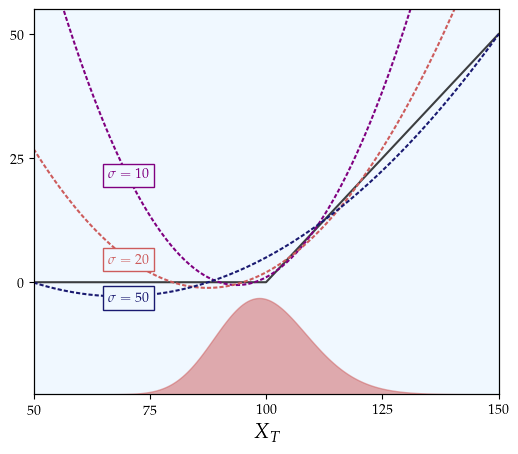

In [5]:
#============= Terminal payoff =============#
xs = np.linspace(0.5*x0,1.5*x0,201) # Space grid
G  = g(xs[__,:])                    # Terminal payoff 
    
col = 'midnightblue'
cols = ["purple","indianred","midnightblue", "darkred",'mediumpurple','tomato','indianred',"plum","gold","steelblue"]
colCyc = cyc('color', cols)

save = 1
fig,ax = plt.subplots(1,1,figsize = (6,5))
ax.set_facecolor("aliceblue"); ax.set_prop_cycle(colCyc)#ax.set_prop_cycle(cyc('linestyle',['-','--','-.',':']))
ax.plot(xs,G,lw = 1.5,color = "k",label = "Call payoff",alpha = 0.75,zorder = -4) 
#ax.text(xs[160]-0.06,G[160]-0.1,r"$(X_T - X_0)^+$",color = col,alpha = 0.6,fontsize = 16)
# Replication using Bachelier embeddings / FTE
i = 0
for sig in x0*np.array([0.1,0.2,0.5]):
    # FTE coefficients
    lbda = statRep(sig) 
    # Taylor approximation (see equation (25) in the text)
    GHat = lbda["_"] + lbda["t"] * T + lbda["x"] * (xs - x0) \
         + lbda["xx"] * (xs - x0)**2/2
    zorder = 2 if sig == sigBS else 0 
    ax.plot(xs,GHat,dashes = (2,1),lw = 1.5,label = r"$\sigma = %2.f$"%sig,zorder = zorder)
    ax.text(xs[40]- 4,GHat[40]-1,r"$\sigma = %2.f$"%sig,fontsize = 10,color = cols[i],
                    bbox = dict(edgecolor = cols[i],facecolor = 'aliceblue', pad=3.5))#,color = col
    i += 1
# Add Risk-neutral distribution of X_T (here log normal)
ax2    = ax.twinx()
rnDist = lognorm.pdf(xs, s = sigBS*np.sqrt(T),scale = np.exp(np.log(x0) - sigBS**2 * T/2))
ax2.fill_between(xs,0.,rnDist,zorder = -2,alpha = 0.5,color = cols[1])
ax2.set_yticks([]); ax2.set_ylim(0.,4*np.max(rnDist))
ax.set_xlim(np.min(xs),np.max(xs)); ax.set_ylim(np.min(GHat)*0.9 - 0.2*x0,np.max(G)*1.1)
ax.set_xticks(np.quantile(xs,np.linspace(0,1,5))); ax.set_yticks([0,0.25*x0,0.5*x0])
ax.set_xlabel(r"$X_T$",fontsize = 15)
if save: plt.savefig("Figures/callReplication, sigBS = %2.2f.pdf"%sigBS,dpi = 500,bbox_inches ="tight",pad_inches = 0.15)
plt.show()

### Price

Initial price as function of Bachelier volatility and order $k = 0,1,2$.

BS price: 3.99


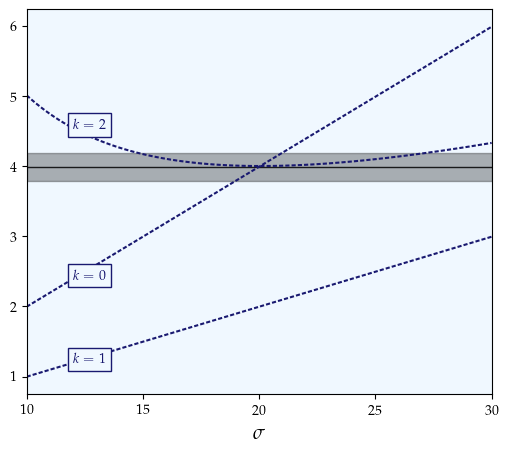

In [11]:
def pHat(lbda):
    """FTE price given the coefficients (lbda^I). Order = 1,2,3."""
    # Risk neutral variance in the Black-Scholes model
    Var  = x0**2 * (np.exp(sigBS**2 * T) - 1)
    pHat = {}
    # Order 0 (use Bachelier price)
    pHat[0] = lbda["_"]
    # Order 1
    pHat[1] = pHat[0] + lbda["t"] * T
    # Order 2
    pHat[2] = pHat[1]   + lbda["xx"] * Var/2 
    return pHat

#============= Initial Price vs sig =============#
pBS,*_ = bsVanilla(x0,kappa,r,delta,sigBS,T)
print("BS price: %2.2f"%pBS)

sigs = x0 * np.linspace(0.1,0.3,101) # Volatility grid
nSig = len(sigs)

ps = np.zeros((3,nSig))
# Replication using Bachelier embeddings / FTE
for i in range(nSig):
    # FTE coefficients
    lbda    = statRep(sig = sigs[i])
    # Approximated prices
    ps[:,i] = list(pHat(lbda).values()) 
  
# Plot
col    = 'midnightblue'
save   = 1
fig,ax = plt.subplots(1,1,figsize = (6,5))
ax.set_facecolor("aliceblue")

ax.hlines(pBS,sigs[0],sigs[-1],ls = "-",color = "k",alpha = 0.85,lw = 1)
ax.fill_between(sigs,pBS*0.95,pBS*1.05,color = "k",alpha = 0.3)
yMin,yMax = np.min(ps)*0.95,np.max(ps)*1.05

for k in [0,1,2]:
    ax.plot(sigs,ps[k,:],lw = 1.5,dashes = (2,1),color = cols[2])
    ax.text(sigs[10],ps[k,10],r"$k = %d$"%k,fontsize = 10,color = cols[2],
            bbox = dict(edgecolor = cols[2],facecolor = 'aliceblue', pad=3.5))
    
ax.set_xlim(np.min(sigs),np.max(sigs))
ax.set_xticks(np.arange(sigs[0],sigs[-1]+1,5))
ax.set_xlabel(r"$\sigma$",fontsize = 15)
if save: plt.savefig("Figures/callPrice.pdf",dpi = 500,bbox_inches ="tight",pad_inches = 0.15)
plt.show()

### Asian Option
$$    g(X) = \left(\bar{a}(X) - K \right)^+, \quad  \bar{a}(X) = \frac{1}{T}\int_0^t X_udu,  \quad X \in \Lambda_u. $$

Recall that 
$$f_{\sigma}(X) = p_{\sigma}(t,a(X)), \quad p_{\sigma}(t,a):= p^{\text{BA}}(t,a,h(t,\sigma)), \quad h(t,\sigma) = \frac{\sigma}{\sqrt{3}}(1-t/T). $$
In particular,  $$\Delta_t f_{\sigma}(X) = \partial_tp_{\sigma}(t,a(X)) = \Theta^{\text{BA}}  - \frac{\sigma}{\sqrt{3}T}\vartheta^{\text{BA}},$$ where $\Theta^{\text{BA}}, \vartheta^{\text{BA}}$ is respectively the Theta and  Vega of a call option in the Bachelier model. 


In [12]:
# Bachelier Embedding
def pAs(tau,a,K,sigBa): 
    """Price of fixed strike Asian call option in Bachelier model. 
       tau = time to maturity."""
    # Scaled volatility for Asian options (note that T is fixed throughout)
    sigAs = sigBa * tau / (np.sqrt(3) * T) 
    return p(tau,a,K,sigAs)[0]

def statRepAsian(sigBa):  
    """Static Replication using Bachelier embeddings. 
       Returns first FTE coefficients. """
    # Scaled volatility for Asian options
    sigAs = sigBa / np.sqrt(3) 
    # Bachelier price of Asian call option and Greeks
    C,_,delta,_,gamma,theta,vega = baVanilla(x0,kappa,sigAs,T)
    # Functional derivatives (FTE coefficients)
    lbda = {"_": C, "t": theta - sigAs / T * vega, "x": delta, "xx": gamma} 
    return lbda

def gHatAsian(xT,aT,lbda,T = T):
    """Taylor approximation of g(X) given the coefficients (lbda^I). 
    Note that the terms S^{(1)}, S^{(0,1)} are grouped together. """
    return lbda["_"] + lbda["t"] * T + lbda["x"] * (aT - x0) + lbda["xx"] * (xT - x0)**2/2

def pHat(lbda):
    """Initial price given the coefficients (lbda^I)."""
    return lbda["_"] + lbda["t"] * T  + lbda["xx"] * (np.exp(sigBS**2 * T) - 1)/2

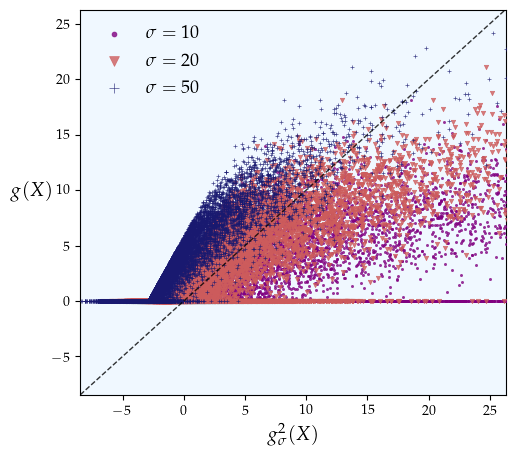

In [13]:
# Payoff
g = lambda X: np.maximum(np.mean(X,axis = 0) - kappa,0.)

# Simulations
# Number of time steps
N = 500                 
ts  = np.linspace(0,T,N+1)  # Time grid (flat)
Ts  = ts[:,__]              # Time grid (column vector)
dt  = T/N                   # Time increments (here constant)

J = 15000#; rdm.seed(11)
X    = x0 * np.exp(sigBS * BM(Ts,J) + (r - sigBS**2/2) * Ts)
G    = g(X)

col = 'midnightblue'
cols = ["purple","indianred","midnightblue"]
colCyc = cyc('color', cols)
markers = ['.','v','+']

# scatter
save   = 1
fig,ax = plt.subplots(1,1,figsize = (5.5,5))
ax.set_facecolor("aliceblue");#markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
ax.set_prop_cycle(colCyc)

i = 0; sigs = x0*np.array([0.10,0.2,0.5])
for sig in sigs:
    lbda = statRepAsian(sig)
    GHat = gHatAsian(X[-1,:],np.mean(X,axis = 0),lbda,T = T)
    
    if sig == sigBS:
        zorder,alpha,s = 3, 0.8,5
    else: 
        zorder,alpha,s = 3, 0.8,10
    ax.scatter(GHat,G,s = s,label = r"$\sigma = %2.f$"%sig, 
               alpha = alpha,linewidths = 0.5, zorder = zorder,marker = markers[i]); i+=1 
        
xMin,xMax = np.min(GHat) - 0.06,np.max(G)# - 0.1  
ax.plot([xMin,xMax],[xMin,xMax],"--",lw = 1,color = "k",alpha = 0.8,zorder = 5)
ax.set_xlim([xMin-0.05,xMax+0.05]); ax.set_ylim([xMin,xMax])
ax.set_xlabel(r"$g_{\sigma}^2(X)$", fontsize = 14);
ax.set_ylabel(r"$g(X)$", fontsize = 14, rotation = 0,labelpad = 15)
#ax.set_xticks([0.,0.1,0.2,0.3]); ax.set_yticks([0.,0.1,0.2,0.3])
lgnd = ax.legend(fontsize = 13,frameon = False)
#lgnd.legendHandles[0].sizes = [50]
for i in range(len(sigs)):
    lgnd.legend_handles[i].set_sizes([50])
#lgnd.legendHandles[0]._legmarker.set_markersize(40)
#ax.grid(color = col,alpha = 0.1)
if save: plt.savefig("Figures/asianReplication, sigBS = %2.2f,T = %2.2f.pdf"%(sigBS,T),dpi = 500,bbox_inches ="tight",pad_inches = 0.15)
plt.show()

BS price: 2.31


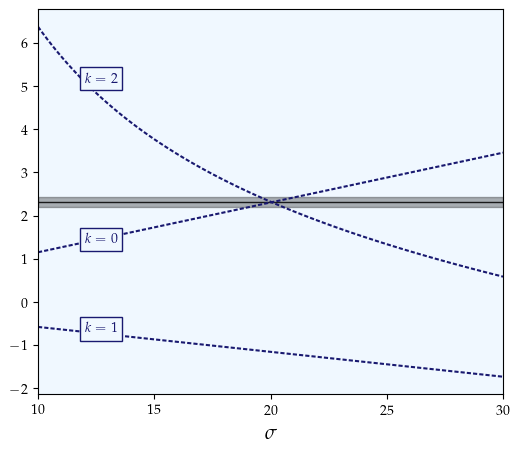

In [14]:
def pHat(lbda):
    """FTE price given the coefficients (lbda^I). Order = 1,2,3."""
    # Risk neutral variance in the Black-Scholes model
    Var  = x0**2 * (np.exp(sigBS**2 * T) - 1)
    pHat = {}
    # Order 0 (use Bachelier price)
    pHat[0] = lbda["_"]
    # Order 1
    pHat[1] = pHat[0] + lbda["t"] * T
    # Order 2
    pHat[2] = pHat[1] + lbda["xx"] * Var/2
    return pHat

#============= Initial Price vs sig =============#
# Monte Carlo price in the Black-Scholes model
J    = int(1e5)
X    = x0 * np.exp(sigBS * BM(Ts,J) + (r - sigBS**2/2) * Ts)
G    = g(X)
pBS  = MC(G,T)

print("BS price: %2.2f"%pBS)

sigs = x0 * np.linspace(0.1,0.3,101) # Volatility grid
nSig = len(sigs)

ps = np.zeros((3,nSig))
# Replication using Bachelier embeddings / FTE
for i in range(nSig):
    # FTE coefficients
    lbda    = statRepAsian(sigs[i])
    # Approximated prices
    ps[:,i] = list(pHat(lbda).values()) 
  
# Plot
col    = 'midnightblue'
save   = 1
fig,ax = plt.subplots(1,1,figsize = (6,5))
ax.set_facecolor("aliceblue")

ax.hlines(pBS,sigs[0],sigs[-1],ls = "-",color = "k",alpha = 0.85,lw = 1)
ax.fill_between(sigs,pBS*0.95,pBS*1.05,color = "k",alpha = 0.3)
yMin,yMax = np.min(ps)*0.95,np.max(ps)*1.05

for k in [0,1,2]:
    ax.plot(sigs,ps[k,:],lw = 1.5,dashes = (2,1),color = cols[2])
    ax.text(sigs[10],ps[k,10],r"$k = %d$"%k,fontsize = 10,color = cols[2],
            bbox = dict(edgecolor = cols[2],facecolor = 'aliceblue', pad=3.5))
    
ax.set_xlim(np.min(sigs),np.max(sigs))
ax.set_xticks(np.arange(sigs[0],sigs[-1]+1,5))
ax.set_xlabel(r"$\sigma$",fontsize = 15)
if save: plt.savefig("Figures/asianPrice.pdf",dpi = 500,bbox_inches ="tight",pad_inches = 0.15)
plt.show()